In [96]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [3]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20181114_CEC_CAL-8-no4_MSpos_1,20181114_CEC_CAL-8-no4_MSpos_2,20181114_CEC_CAL-8-no4_MSpos_3,20181114_CEC_CAL-8-no4_MSpos_4,20181114_CEC_CAL-8-no4_MSpos_5,20181114_CEC_CAL-8-no4_MSpos_6,20181114_CEC_CAL-8-no4_MSpos_7,...,20181114_SR520-Creek_Mix6A_3,20181114_SR520-Creek_Mix6B_1,20181114_SR520-Creek_Mix6B_2,20181114_SR520-Creek_Mix6B_3,20181114_SwanCreek-Dec_1,20181114_SwanCreek-Dec_2,20181114_SwanCreek-Dec_3,20181114_SwanCreek-May_1,20181114_SwanCreek-May_2,20181114_SwanCreek-May_3
0,8.381,100.03931,60.33,0,0,0,0,0,0,0,...,68,82,100,0,0,0,0,0,0,0
1,2.332,100.07604,88.07,412,754,1985,1639,2049,1796,2702,...,674,1609,1571,782,976,729,587,6437,3174,2708
2,2.544,100.11243,111.09,4168,3547,2459,3768,3544,1695,2862,...,2282,1246,1662,2120,840,1336,1665,1200,1191,1217
3,5.359,100.11253,155.25,1239,1145,1007,550,1254,781,1714,...,203706,231624,152532,231635,260914,258902,234764,234498,193185,193974
4,0.628,101.00802,20.59,1295,1499,1508,2067,2103,2153,1500,...,18334,14693,11126,10754,14120,10229,12813,10449,9869,11369


In [4]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [67]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [68]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    drop_index = np.argwhere(np.asarray(d_input[d_input.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    d_thres = d_input.drop(drop_index[0])
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True)
    d_thres.drop(columns=['index'],inplace=True)
    
    col_blank = []
    for key in blank_keyword:
        col_app = [col for col in d_thres.columns if key in col]
        col_blank += col_app
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample]
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])]

    for triplicate in tqdm(trip_list):
        for index, row in d_sample[triplicate].iterrows():
            if (row == 0).sum() > empty_thres:
                d_sample.loc[index, triplicate] = 0
            elif row.std() / row.mean() > cv_thres:
                d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?
    d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]
    
    
    return d_sample

In [69]:
d_sample = data_prep(df_c,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 10/10 [02:07<00:00, 12.75s/it]


In [177]:
def ms_cluster(d_input, select_keyword, normalization='linear', d_reduce=True, d_reduce_method='tsne', perplexity=50, cluster_method='dbscan',eps=0.8,min_samples=10):
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            X=transformed.copy()
    elif d_reduce == False:
        X=d_norm.copy()
    
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)

        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title(str(dbscan)+'label='+ str(k))
            plt.show()

        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index]
        d_label['label'] = c.labels_
    
    return d_label

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


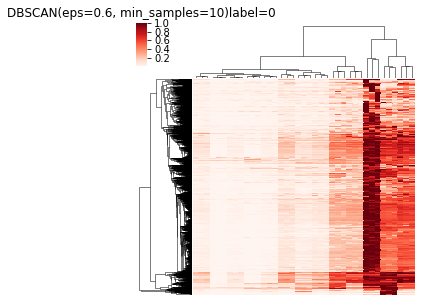

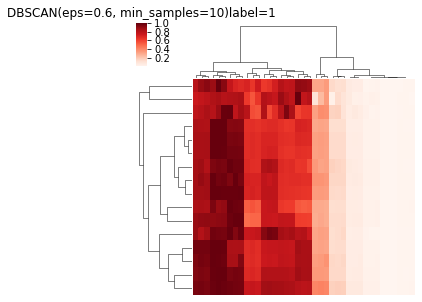

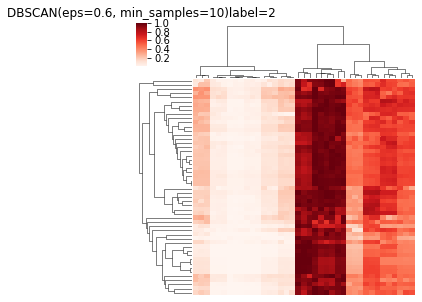

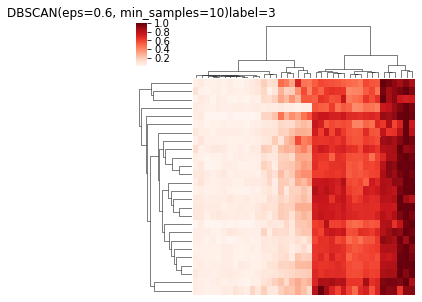

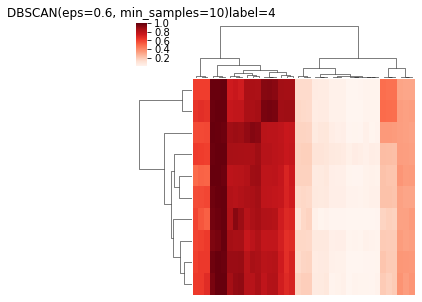

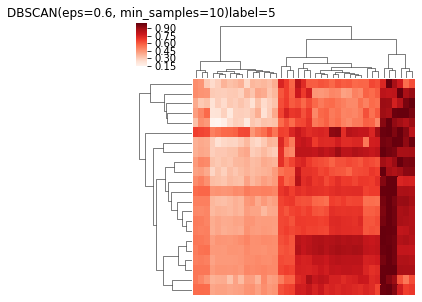

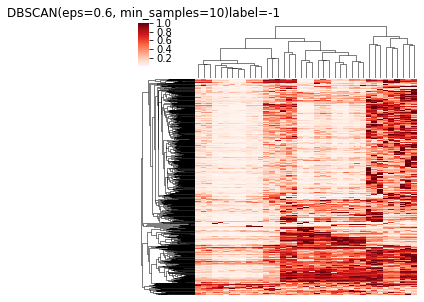

In [182]:
d_label=ms_cluster(d_sample,['SR520-Cal'],'linear',d_reduce=False,eps=0.6)

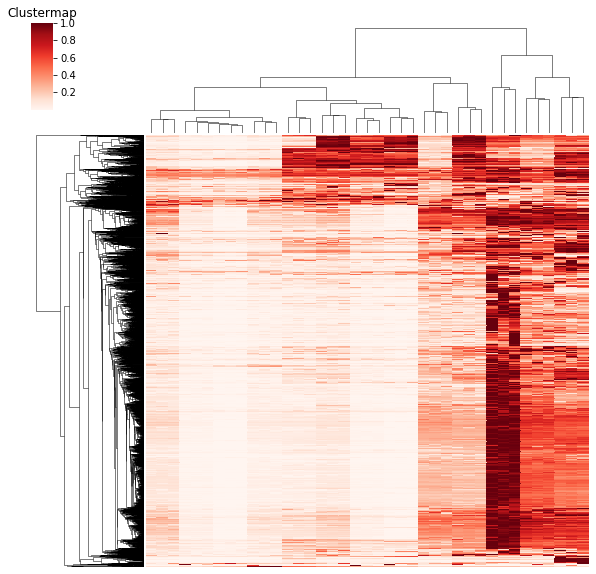

In [156]:
#no 0 is acceptable in the clustermap -- eye balling estimation?
sns.clustermap(d_norm.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

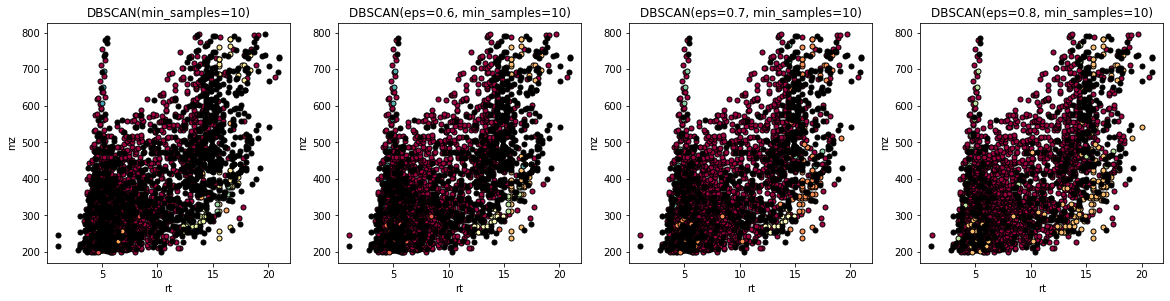

In [29]:
fig = plt.figure(figsize = (20,15))
pd.options.mode.chained_assignment = None
for c,num in zip(c_list,np.arange(1,len(c_list)+1)):
    d_init = d_sample.copy()
    d_label = d_init.loc[d_norm.index]
    d_label['label'] = c.labels_

    #Plot
    unique_labels = set(d_label['label'])
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
                 
    ax = fig.add_subplot(3, 4,num)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        ax.plot(d_label[d_label['label']==k]['Average RT (min)'], d_label[d_label['label']==k]['Average m/z'], 'o',markersize=5, markerfacecolor=tuple(col),
                 markeredgecolor='k')
        #plt.colorbar()
        ax.set_xlabel('rt')
        ax.set_ylabel('mz')
        ax.set_title(str(c))
plt.show()

In [ ]:
options: all_data/clusters seperately
models: multiple linear/ random forest/ etc..
def modeling:
    select option
    select model
    if option all_data:
        model.fit(data) --> training 1114data, test 0815data
    elif option cluster:
        for group in cluster:
            model.fit(group)
        all_model -- > final_model

In [ ]:
post filtering of dilution cluster
source tracking:
    1. samples from different sites
    2. vann diagram--> 'source subtraction' --> unique features for different source
    3. use cluster/noise distinguish method --> remove noises, get clusters
    4. source proportioning prediction 

# How we changed d_norm before running method

In [ ]:
#visualization
#Normalization to 0 1 scale
#c_data = d_sample[4:].values #returns a numpy array
c_data = d_dilu.values


#Normalized to absolute values
c_norm = []
for row in c_data:
    c_norm.append(row/max(row))
c_norm = np.asarray(c_norm)
#Normalized to relative values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(c_data.T)
# df=pd.DataFrame(x_scaled)

# added RT and MZ values back from the main dataframe so that we can keep using them to visualize!
d_norm = pd.DataFrame(c_norm)
d_norm.insert(0,"RT", d_sample['Average RT (min)'].tolist())
d_norm.insert(1,"MZ", d_sample['Average m/z'].tolist())
d_norm = d_norm.dropna()
d_norm = d_norm.reset_index(drop=True)

# Trend Clustering Method 

In [ ]:
def trend_calc(df):
    cluster = [] # keep track of cluster number
    clusters = [] # what are current clusters?
    cluster_list = [] # what rows go into each cluster?
    noise = []
    df = df.reset_index(drop=True)
    while len(df) > 0:
        for row in range(len(df)):
            feature_1 = df.iloc[0]
            feature_2 = df.iloc[row]
            corr, p_val = scipy.stats.pearsonr(df.iloc[0, 2:], df.iloc[row, 2:])
            if p_val < 0.05:
                cluster_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) == 1:
            noise += [cluster]
            cluster = []
        else:
            clusters += [cluster]
            cluster = []
        df = df.drop(cluster_list)
        df = df.reset_index(drop=True)
        cluster_list = []
    return clusters, noise

# Running Trend Cluster Algorithm

In [2]:
clusters,noise=trend_calc(d_norm)     

# Visualization

In [ ]:
rt=[]
mz=[]
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        rt.append(clusters[i][j].loc['RT'])
        mz.append(clusters[i][j].loc['MZ'])
    plt.scatter(rt,mz,label=i)
    rt=[]
    mz=[]
rt2=[]
mz2=[]
for k in range(len(noise)):
    rt2.append(noise[k][0].loc['RT'])
    mz2.append(noise[k][0].loc['MZ'])
plt.scatter(rt2,mz2,label='noise')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')